In [1]:
import time

import matplotlib.pyplot as plt

# import kernelforge
# help(kernelforge._fchl19)
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

from kernelforge._fchl19 import (
    fatomic_local_gradient_kernel,
    fgdml_kernel,
    fgdml_kernel_symm,
    flocal_kernel,
    flocal_kernel_symm,
    generate_fchl_acsf,
    generate_fchl_acsf_and_gradients,
)
from kernelforge._kernels import solve_cholesky

In [2]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
elements=[1, 6, 8]
n_train = 1000
n_test = 999

In [3]:
X = np.asarray([generate_fchl_acsf(r, train["z"], elements=elements) for r in tqdm(train["R"][:n_train])])
dX = np.asarray([generate_fchl_acsf_and_gradients(r, train["z"], elements=elements)[1] for r in tqdm(train["R"][:n_train])])
Q = np.asarray([train["z"] for r in train["R"][:n_train]])
N = np.asarray([len(train["z"]) for r in train["R"][:n_train]])

Yf = train["F"][:n_train].flatten()
Yscal = np.std(Yf)
Yf /= Yscal
# Yf = -Yf
Y = train["E"][:n_train].flatten()
offset = np.mean(train["E"])
Y -= offset

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
Xt = np.asarray([generate_fchl_acsf(r, test["z"], elements=elements) for r in tqdm(test["R"][:n_test])])
dXt = np.asarray([generate_fchl_acsf_and_gradients(r, test["z"], elements=elements)[1] for r in tqdm(test["R"][:n_test])])
Qt = np.asarray([test["z"] for r in test["R"][:n_test]])
Nt = np.asarray([len(test["z"]) for r in test["R"][:n_test]])

Yft = test["F"][:n_test].flatten()
# Yft /= Yscal

Yt = test["E"].flatten()[:n_test] - offset

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [5]:
sigma = 2
t0 = time.perf_counter()
H = fgdml_kernel_symm(X, dX, Q, N, sigma)
t1 = time.perf_counter()
print(H.shape)
print(t1-t0)

(27000, 27000)
33.48766856401926


In [6]:
K_solve = H.copy()
for i in range(K_solve.shape[0]):
    K_solve[i,i] += 1e-8
t0 = time.perf_counter()
alphas = solve_cholesky(K_solve, Yf)
t1 = time.perf_counter()
print(t1)
print(alphas)

259574.725077111
[-193988.96642823 -403887.80598284 -207717.59182991 ... -485458.13651257
 -120044.08228104   76367.18568668]


In [7]:
t0 = time.perf_counter()
Kp = fatomic_local_gradient_kernel(Xt, X, dX, Qt, Q, Nt, N, sigma)
print(Kp.shape)
t1 = time.perf_counter()
print(t1-t0)

(999, 27000)
14.496513087011408


In [8]:
Yp = Kp @ alphas * Yscal
Yp -= np.mean(Yp)

RMSE = 0.1725954689268866
PearsonRResult(statistic=np.float64(0.9999614614112914), pvalue=np.float64(0.0))


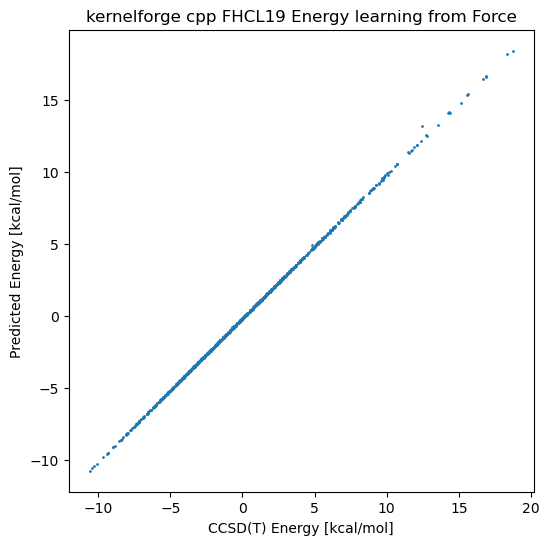

In [13]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yp, Yt)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.title("kernelforge cpp FHCL19 Energy learning from Force")
plt.scatter(Yt, Yp, s=1)

In [10]:
t0 = time.perf_counter()
Ht = fgdml_kernel(Xt, X, dXt, dX, Qt, Q, Nt, N, sigma).T
t1 = time.perf_counter()
print(Ht.shape)
print(t1-t0)

(26973, 27000)
47.55051377299242


In [11]:
Yfp = Ht @ alphas * Yscal
Yfp.shape

(26973,)

RMSE = 0.23369065306625653
PearsonRResult(statistic=np.float64(0.9999638113839161), pvalue=np.float64(0.0))


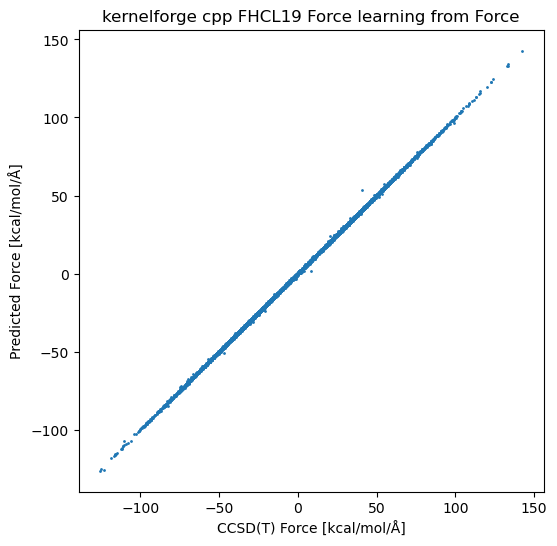

In [14]:
rmse = np.sqrt(np.mean(np.square(Yft - Yfp)))
res = pearsonr(Yfp, Yft)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")
plt.title("kernelforge cpp FHCL19 Force learning from Force")
plt.scatter(Yft, Yfp, s=1)